# CTEFNet: ENSO Forecast Based on CNN and Transfer Learning

[![DownloadNotebook](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_notebook_en.svg)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindearth/en/medium-range/mindspore_graphcast.ipynb)&emsp;[![DownloadCode](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_download_code_en.svg)](https://obs.dualstack.cn-north-4.myhuaweicloud.com/mindspore-website/notebook/master/mindearth/en/medium-range/mindspore_graphcast.py)&emsp;[![ViewSource](https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/website-images/master/resource/_static/logo_source_en.svg)](https://gitee.com/mindspore/docs/blob/master/docs/mindearth/docs/source_en/medium-range/graphcast.ipynb)

## Overview

CTEFNet is an ENSO forecast model based on deep learning. It uses 2D CNN to extract features from climate data. Multiple time point features are merged into time series and then input into Transformer Encoder for time series analysis and ENSO prediction.
Compared with previous deep learning models, CTEFNet's effective prediction time is extended to 19 months.

This tutorial introduces the research background and technical path of CTEFNet, and shows how to train and fast infer the model through MindEarth.

## CTEFNet

The following figure shows the CTEFNet network architecture.

<img src="images/CTEFNet.png" alt="CTEFNet" style="width: 800px;"/>

CTEFNet mainly consists of two parts: CNN feature extractor and Transformer encoder.

The CNN part includes three  2d convolutional layers and three maximum pooling layers; the monthly abnormal values of ocean and atmospheric indicators for 12 consecutive months are used as input.

The extracted features are concatenated into sequences and analyzed by the Transformer encoder. The Transformer encoder is combined with the CNN to form a residual structure. Finally, the fully connected layer outputs the Nino3.4 index estimate for the 12-month observation period and the Nino3.4 index prediction for the subsequent 23 months.

## Technology Path

MindSpore Earth solves the problem as follows:

1. Data Construction.
2. Model Construction.
3. Loss function.
4. Model Training.
5. Model Evaluation and Visualization.

Download the training and test dataset: [mindearth/dataset](https://download-mindspore.osinfra.cn/mindscience/mindearth/dataset/enso_dataset.zip) .

In [1]:
import os
import random

import numpy as np

from mindspore import set_seed
from mindspore import context
import mindspore.dataset as ds
from mindspore.train.serialization import load_param_into_net

The following `src` can be downloaded in [ensoforcast/src](https://gitee.com/mindspore/mindscience/tree/master/MindEarth/applications/medium-range/ensoforecast/src).

In [2]:
from mindearth.module import Trainer
from mindearth.utils import load_yaml_config, create_logger
from src import WeightedLoss, CTEFNet, InferenceModule, EvaluateCallBack
from src import ReanalysisData, plot_correlation, get_param_dict, init_dataloader

In [3]:
set_seed(0)
np.random.seed(0)
random.seed(0)

You can get parameters of model, data and optimizer from [config](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/medium-range/ensoforecast/configs/pretrain.yaml) .

In [4]:
config = load_yaml_config("./configs/pretrain.yaml")
context.set_context(mode=context.PYNATIVE_MODE, device_target="GPU", device_id=0)

## Data Construction

Download the statistic, training and validation dataset from [dataset](https://download-mindspore.osinfra.cn/mindscience/mindearth/dataset/enso_dataset.zip) to `./dataset`.

Modify the parameter of `root_dir` in the [configs/pretrain.yaml](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/medium-range/ensoforcast/configs/pretrain.yaml) and [configs/finetune.yaml](https://gitee.com/mindspore/mindscience/blob/master/MindEarth/applications/medium-range/ensoforcast/configs/finetune.yaml), which set the directory for dataset.

The `./dataset` is hosted with the following directory structure:

``` markdown
.
dataset
├── CMIP5_nino34.npy
├── CMIP5_sst_ssh_slp.npy
├── SODA_nino34.npy
└── SODA_sst_ssh_slp.npy

```

## Model Construction


The initialization of the model:

In [5]:
config['data']['obs_time'] = 12 # Observation time length
config['data']['pred_time'] = 23 # Predition time length
logger = create_logger(os.path.join(os.path.abspath(config['summary']["summary_dir"]), "results.log"))

In [6]:
data_params = config.get("data")
model_params = config.get("model")
model = CTEFNet(
        cov_hidden_channels=model_params.get('cov_hidden_channels'),
        cov_out_channels=model_params.get('cov_out_channels'),
        heads=model_params.get('heads'),
        num_layer=model_params.get('num_layer'),
        feedforward_dims=model_params.get('feedforward_dims'),
        dropout=model_params.get('dropout'),
        obs_time=data_params.get('obs_time'),
        pred_time=data_params.get('pred_time')
    )

## Loss Function

CTEFNet uses custom weighted loss for model training. The function was:

<img src="images/Loss.png" alt="Loss" style="width: 600px;"/>

In [7]:
opt_params = config.get("optimizer")
loss_fn = WeightedLoss(
    lambda_1=opt_params.get('loss_alpha'),
    lambda_2=opt_params.get('loss_beta'),
    lambda_3=opt_params.get('loss_gamma'),
    obs_time=data_params.get('obs_time')
)

## Model Training

In this tutorial, we inherite the Trainer and override `get_dataset` member function to load custom data, override `get_callback` member function to perform inference on the test dataset during the training process. Model training can be divided into two steps: pre-training and fine-tuning.

MindSpore Earth provides training and inference interface for model training with `MindSpore` version >= 2.0.0.

In [8]:
class CTEFTrainer(Trainer):
    def __init__(self, config, model, loss_fn, logger):
        super().__init__(config, model, loss_fn, logger)
        self.train_dataset, self.valid_dataset = self.get_dataset()
        self.pred_cb = self.get_callback()

    def get_callback(self):
        pred_cb = EvaluateCallBack(self.model, self.valid_dataset, self.config, self.logger)
        return pred_cb


    def get_dataset(self):
        train_dataloader, valid_dataloader = init_dataloader(self.config)
        return train_dataloader, valid_dataloader

Pre-trained using CMIP5 data.

In [9]:
config['data']["train_dataset"] = "CMIP5" # Training set
config['data']["train_period"] = [1861, 2004] # Training period
config['data']["valid_dataset"] = "Reanalysis" # validation set
config['data']["valid_period"] = [1941, 1983] # validation period
config['data']["t_in"] = 1  # Training stage
config['data']["t_out_train"] = 1  # Training stage
config['optimizer']['name'] = 'adam'  # Optimizer name
config['optimizer']['initial_lr'] = 0.0008  # Learning rate
config['optimizer']['epochs'] = 3  # Training epoch

trainer = CTEFTrainer(config, model, loss_fn, logger)
trainer.train()

2024-01-04 17:09:53,354 - pretrain.py[line:215] - INFO: steps_per_epoch: 60


epoch: 1 step: 1, loss is 1.5182791
epoch: 1 step: 2, loss is 1.5837412
epoch: 1 step: 3, loss is 1.5687228
epoch: 1 step: 4, loss is 1.5529883
epoch: 1 step: 5, loss is 1.5631034
epoch: 1 step: 6, loss is 1.5315193
epoch: 1 step: 7, loss is 1.4964404
epoch: 1 step: 8, loss is 1.6084869
epoch: 1 step: 9, loss is 1.4317186
epoch: 1 step: 10, loss is 1.3057781
epoch: 1 step: 11, loss is 1.274146
epoch: 1 step: 12, loss is 1.1803966
epoch: 1 step: 13, loss is 1.3376935
epoch: 1 step: 14, loss is 1.3478584
epoch: 1 step: 15, loss is 1.2935078
epoch: 1 step: 16, loss is 1.1874846
epoch: 1 step: 17, loss is 1.1050987
epoch: 1 step: 18, loss is 1.0307624
epoch: 1 step: 19, loss is 1.0223571
epoch: 1 step: 20, loss is 1.0439371
epoch: 1 step: 21, loss is 0.9886076
epoch: 1 step: 22, loss is 0.9710097
epoch: 1 step: 23, loss is 0.88749564
epoch: 1 step: 24, loss is 0.83498174
epoch: 1 step: 25, loss is 0.8129358
epoch: 1 step: 26, loss is 0.85638297
epoch: 1 step: 27, loss is 0.8833265
epoch: 1

Fine-tuning using pre-1984 SODA reanalysis data

In [10]:
config['data']["train_dataset"] = "Reanalysis" # Training set
config['data']["train_period"] = [1941, 1983] # Training period
config['data']["valid_dataset"] = "Reanalysis" # validation set
config['data']["valid_period"] = [1984, 2008] # validation period
config['data']["t_in"] = 2  # Training stage
config['data']["t_out_train"] = 1  # Training stage
config['optimizer']['name'] = 'sgd'  # Optimizer name
config['optimizer']['finetune_lr'] = 0.001  # Fine-tune learning rate
config['optimizer']['epochs'] = 100  # Fine-tune epoch

trainer = CTEFTrainer(config, model, loss_fn, logger)
trainer.train()

2024-01-04 17:11:06,569 - pretrain.py[line:215] - INFO: steps_per_epoch: 1


epoch: 1 step: 1, loss is 0.61560714
Train epoch time: 2055.669 ms, per step time: 2055.669 ms
epoch: 2 step: 1, loss is 0.58329463
Train epoch time: 2326.359 ms, per step time: 2326.359 ms
epoch: 3 step: 1, loss is 0.55557144
Train epoch time: 392.554 ms, per step time: 392.554 ms
epoch: 4 step: 1, loss is 0.5530031
Train epoch time: 394.613 ms, per step time: 394.613 ms
epoch: 5 step: 1, loss is 0.5358207
Train epoch time: 863.843 ms, per step time: 863.843 ms
epoch: 6 step: 1, loss is 0.53078103
Train epoch time: 393.652 ms, per step time: 393.652 ms
epoch: 7 step: 1, loss is 0.5277782
Train epoch time: 401.477 ms, per step time: 401.477 ms
epoch: 8 step: 1, loss is 0.5282854
Train epoch time: 394.892 ms, per step time: 394.892 ms
epoch: 9 step: 1, loss is 0.51547956
Train epoch time: 394.976 ms, per step time: 394.976 ms
epoch: 10 step: 1, loss is 0.5200441
Train epoch time: 814.040 ms, per step time: 814.040 ms
epoch: 11 step: 1, loss is 0.5064292
Train epoch time: 352.751 ms, per

epoch: 89 step: 1, loss is 0.39276436
Train epoch time: 244.567 ms, per step time: 244.567 ms
epoch: 90 step: 1, loss is 0.39129978
Train epoch time: 741.366 ms, per step time: 741.366 ms
epoch: 91 step: 1, loss is 0.38780504
Train epoch time: 251.739 ms, per step time: 251.739 ms
epoch: 92 step: 1, loss is 0.3935294
Train epoch time: 252.401 ms, per step time: 252.401 ms
epoch: 93 step: 1, loss is 0.39000306
Train epoch time: 249.758 ms, per step time: 249.758 ms
epoch: 94 step: 1, loss is 0.38844264
Train epoch time: 252.133 ms, per step time: 252.133 ms
epoch: 95 step: 1, loss is 0.38856846
Train epoch time: 738.786 ms, per step time: 738.786 ms
epoch: 96 step: 1, loss is 0.39583182
Train epoch time: 248.755 ms, per step time: 248.755 ms
epoch: 97 step: 1, loss is 0.39176747
Train epoch time: 240.972 ms, per step time: 240.972 ms
epoch: 98 step: 1, loss is 0.38904893
Train epoch time: 240.452 ms, per step time: 240.452 ms
epoch: 99 step: 1, loss is 0.39654502
Train epoch time: 243.8

## Model Evaluation and Visualization

After training, we use the checkpoint for inference. The following shows the correlation coefficient between the predicted value and the true value of the nino3.4 index.

In [11]:
test_dataset = ReanalysisData(
    data_params.get('root_dir'),
    data_params.get('test_period'),
    data_params.get('obs_time'),
    data_params.get('pred_time')
)
test_dataloader = ds.GeneratorDataset(
    test_dataset,
    ["data", "index"],
    shuffle=False).batch(data_params.get('valid_batch_size'), False)

In [12]:
corr_list = []
for t in range(1, 2+1):
    param_dict, file_dir = get_param_dict(config, t)
    load_param_into_net(model, param_dict)
    logger.info(f"Load pre-trained model successfully, {file_dir}")
    inference_module = InferenceModule(model, config, logger)
    corr_list.append(inference_module.eval(test_dataloader)[data_params.get('obs_time'):])

2024-01-04 17:11:56,021 - 2085024365.py[line:5] - INFO: Load pre-trained model successfully, ./summary/ckpt/step_1


OBS Accuracy: 95.08%, Pred Accuracy: 65.63%, Pred Corr:
[0.95 0.91 0.88 0.83 0.79 0.74 0.71 0.7  0.7  0.7  0.68 0.68 0.67 0.66
 0.64 0.63 0.59 0.52 0.5  0.45 0.42 0.37 0.38]


2024-01-04 17:11:57,095 - 2085024365.py[line:5] - INFO: Load pre-trained model successfully, ./summary/ckpt/step_2


OBS Accuracy: 94.15%, Pred Accuracy: 67.44%, Pred Corr:
[0.95 0.91 0.88 0.83 0.79 0.75 0.71 0.71 0.7  0.7  0.71 0.71 0.7  0.69
 0.67 0.66 0.63 0.56 0.53 0.47 0.44 0.41 0.4 ]


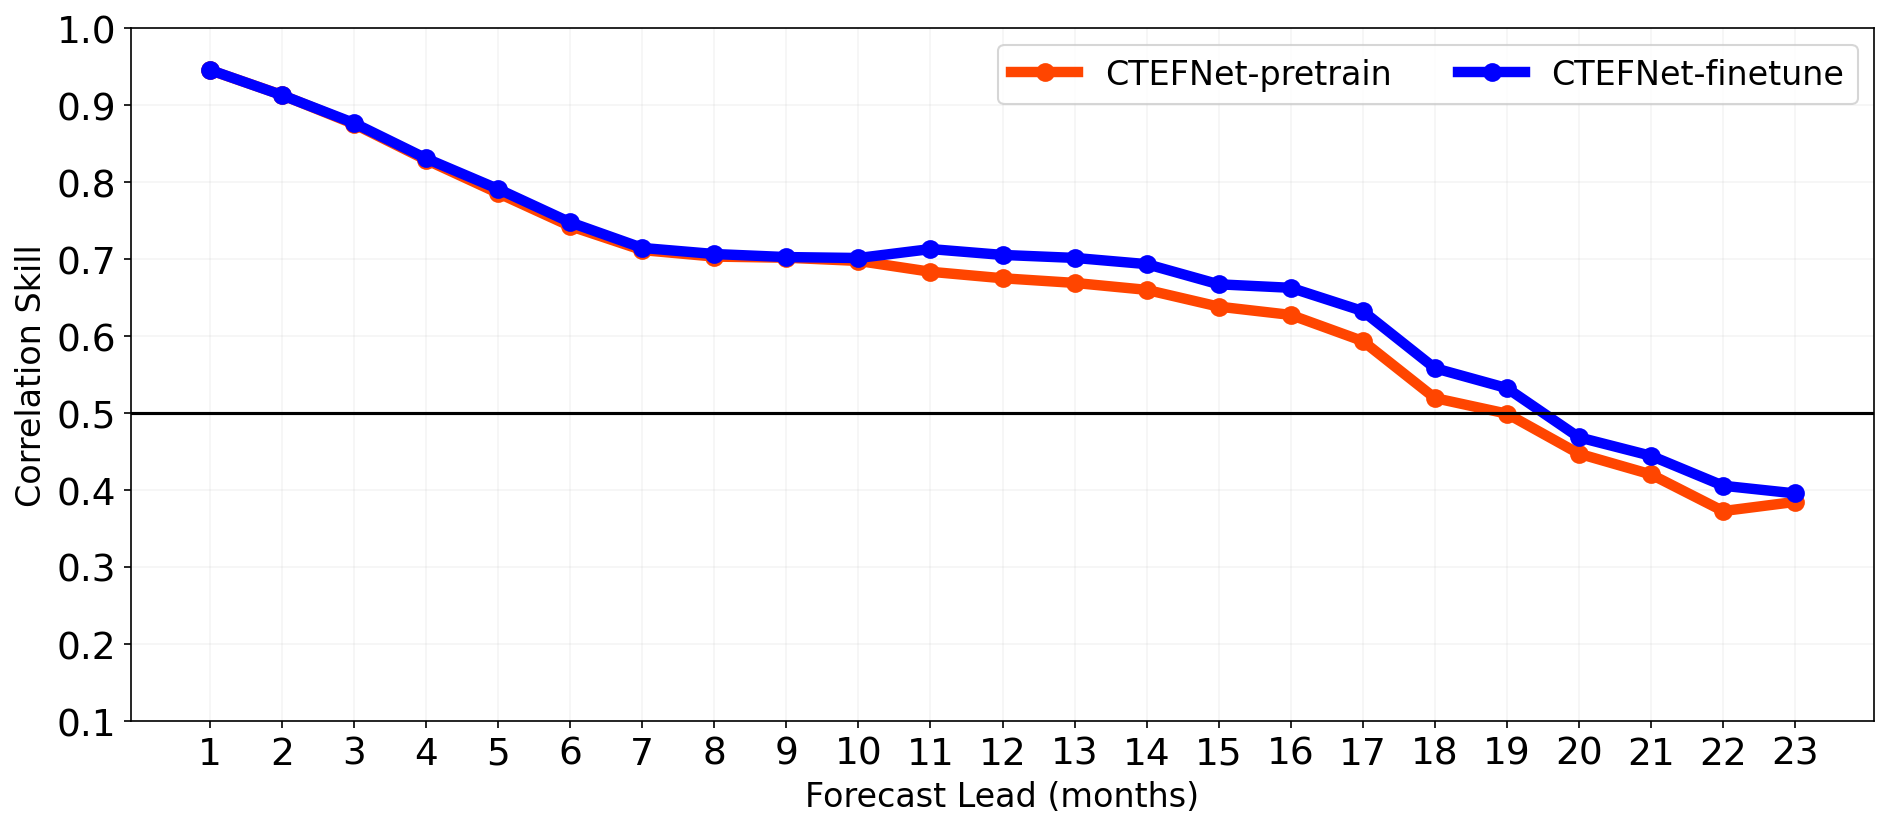

In [13]:
plot_correlation(config, corr_list)